In [1]:
import pandas as pd

In [2]:
df = pd.read_csv('multi_touch_attribution_data.csv')

In [3]:
df.head()

,User ID,Timestamp,Channel,Campaign,Conversion
0,83281,2025-02-10 07:58:51,Email,New Product Launch,No
1,68071,2025-02-10 23:38:48,Search Ads,Winter Sale,No
2,90131,2025-02-11 10:41:07,Social Media,Brand Awareness,Yes
3,71026,2025-02-10 08:19:44,Direct Traffic,-,Yes
4,94486,2025-02-10 15:15:46,Email,Retargeting,Yes


In [4]:
df.dtypes

User ID        int64
Timestamp     object
Channel       object
Campaign      object
Conversion    object
dtype: object

In [5]:
df.isna().sum()

User ID       0
Timestamp     0
Channel       0
Campaign      0
Conversion    0
dtype: int64

In [6]:
df.nunique()

User ID       2847
Timestamp     9737
Channel          6
Campaign         6
Conversion       2
dtype: int64

In [7]:
df.duplicated().sum()

0

In [8]:
for col in ["Channel", "Campaign", "Conversion"]:
    df[col] = df[col].astype(str).str.strip().str.title()

In [9]:
conv_map = {"Yes": 1, "No": 0, "1": 1, "0": 0, "True": 1, "False": 0}
df["conversion_flag"] = df["Conversion"].map(conv_map).fillna(0).astype(int)

In [10]:
df["User ID"] = df["User ID"].astype(str)

In [11]:
df["Timestamp"] = pd.to_datetime(df["Timestamp"], errors="coerce", utc=True)

In [12]:
df["Channel"] = df["Channel"].astype("category")
df["Campaign"] = df["Campaign"].astype("category")

In [13]:
df["conversion_flag"] = df["conversion_flag"].astype(int)

In [14]:
df.dtypes

User ID                         object
Timestamp          datetime64[ns, UTC]
Channel                       category
Campaign                      category
Conversion                      object
conversion_flag                  int64
dtype: object

In [16]:
dup_subset = ["User ID", "Timestamp", "Channel", "Campaign", "conversion_flag"]
n_dupes = df.duplicated(subset=dup_subset, keep=False).sum()
n_dupes

0

In [17]:
touch_counts = df.groupby("User ID").size()
high_touch_thresh = touch_counts.quantile(0.99)   # top 1% users by touches
high_touch_users = touch_counts[touch_counts >= high_touch_thresh]

In [18]:
multi_conv_users = df.groupby("User ID")["conversion_flag"].sum()
multi_conv_users = multi_conv_users[multi_conv_users > 1]

In [19]:
first_conv_ts = df[df["conversion_flag"] == 1].groupby("User ID")["Timestamp"].min()
df_with_first = df.join(first_conv_ts.rename("first_conv_ts"), on="User ID")
post_conv_events = df_with_first[df_with_first["Timestamp"] > df_with_first["first_conv_ts"]]


In [20]:
print("High-touch users flagged:", len(high_touch_users), 
      f"(threshold = {high_touch_thresh:.1f})")
print("Users with more than one conversion:", len(multi_conv_users))
print("Number of post-conversion events:", len(post_conv_events))

High-touch users flagged: 63 (threshold = 8.0)
Users with more than one conversion: 1474
Number of post-conversion events: 5146


In [21]:
events = len(df)
unique_users = df["User ID"].nunique()
overall_cvr = df["conversion_flag"].mean()

In [22]:
campaign_start = df['Timestamp'].min()
campaign_end = df['Timestamp'].max()

In [23]:
print("Global metrics")
print("--------------")
print("Events (rows):", events)
print("Unique users:", unique_users)
print(f"Overall conversion rate: {overall_cvr:.2%}")
print("Campaign duration (min–max):", campaign_start, "→", campaign_end)

Global metrics
--------------
Events (rows): 10000
Unique users: 2847
Overall conversion rate: 49.44%
Campaign duration (min–max): 2025-02-10 00:00:22+00:00 → 2025-02-11 23:59:58+00:00


In [24]:
chan_counts = df["Channel"].value_counts().rename_axis("Channel").to_frame("events")
chan_cvr = df.groupby("Channel")["conversion_flag"].mean().to_frame("event_level_cvr")
channel_summary = chan_counts.join(chan_cvr, how="left").reset_index()
channel_summary["event_share"] = channel_summary["events"] / events
channel_summary = channel_summary.sort_values("events", ascending=False)

print("\nChannel distribution (top):")
print(channel_summary.head(10))


Channel distribution (top):
          Channel  events  event_level_cvr  event_share
0  Direct Traffic    1721         0.495642       0.1721
1        Referral    1685         0.499110       0.1685
2     Display Ads    1669         0.496105       0.1669
3    Social Media    1662         0.493381       0.1662
4           Email    1654         0.501814       0.1654
5      Search Ads    1609         0.479801       0.1609


/var/folders/2y/200s60hs0g5bg1dmy0zrklmr0000gn/T/ipykernel_53364/3616986978.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  chan_cvr = df.groupby("Channel")["conversion_flag"].mean().to_frame("event_level_cvr")


In [25]:
camp_counts = df["Campaign"].value_counts().rename_axis("Campaign").to_frame("events")
camp_cvr = df.groupby("Campaign")["conversion_flag"].mean().to_frame("event_level_cvr")
campaign_summary = camp_counts.join(camp_cvr, how="left").reset_index()
campaign_summary = campaign_summary.sort_values("events", ascending=False)

print("\nTop 10 campaigns by volume:")
print(campaign_summary.head(10))


Top 10 campaigns by volume:
             Campaign  events  event_level_cvr
0                   -    3131         0.495688
1  New Product Launch    1416         0.477401
2         Retargeting    1379         0.495286
3     Brand Awareness    1378         0.506531
4         Winter Sale    1372         0.486152
5      Discount Offer    1324         0.504532


/var/folders/2y/200s60hs0g5bg1dmy0zrklmr0000gn/T/ipykernel_53364/342776711.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  camp_cvr = df.groupby("Campaign")["conversion_flag"].mean().to_frame("event_level_cvr")


In [26]:
import seaborn as sns
import matplotlib.pyplot as plt

In [27]:
user_stats = (
    df.groupby("User ID")
      .agg(
          n_touches=("Channel", "size"),
          n_unique_channels=("Channel", "nunique"),
          any_conversion=("conversion_flag", "max")
      )
      .reset_index()
)

In [28]:
print("User-level stats (head):")
print(user_stats.head())

User-level stats (head):
  User ID  n_touches  n_unique_channels  any_conversion
0   10028          2                  2               1
1   10045          2                  2               1
2   10062          3                  3               1
3   10068          5                  2               1
4   10095          6                  4               1


In [29]:
avg_touches_all = user_stats["n_touches"].mean()
avg_touches_conv = user_stats.loc[user_stats["any_conversion"] == 1, "n_touches"].mean()
avg_touches_nonconv = user_stats.loc[user_stats["any_conversion"] == 0, "n_touches"].mean()

print("\nAverage touches per user:")
print(f"  All users: {avg_touches_all:.2f}")
print(f"  Converting users: {avg_touches_conv:.2f}")
print(f"  Non-converting users: {avg_touches_nonconv:.2f}")



Average touches per user:
  All users: 3.51
  Converting users: 3.78
  Non-converting users: 2.13


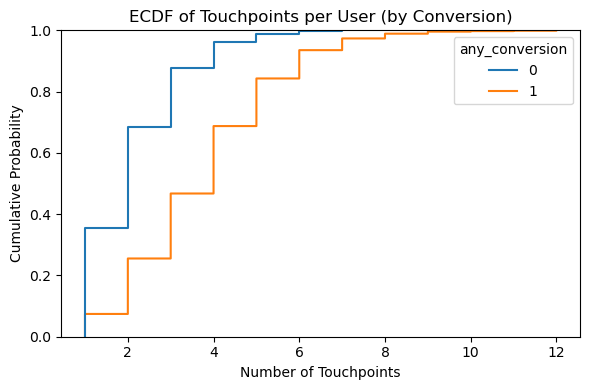

In [30]:
plt.figure(figsize=(6,4))
sns.ecdfplot(data=user_stats, x="n_touches", hue="any_conversion")
plt.title("ECDF of Touchpoints per User (by Conversion)")
plt.xlabel("Number of Touchpoints")
plt.ylabel("Cumulative Probability")
plt.tight_layout()
plt.show()

In [31]:
pathlen_summary = (
    user_stats.groupby("n_touches")
              .agg(users=("User ID","count"),
                   cvr=("any_conversion","mean"))
              .reset_index()
)

print("\nConversion rate by #touches:")
print(pathlen_summary.head(15))


Conversion rate by #touches:
    n_touches  users       cvr
0           1    343  0.516035
1           2    584  0.738014
2           3    595  0.848739
3           4    563  0.930728
4           5    383  0.966057
5           6    224  0.982143
6           7     92  0.989130
7           8     37  1.000000
8           9     16  1.000000
9          10      4  1.000000
10         11      3  1.000000
11         12      3  1.000000


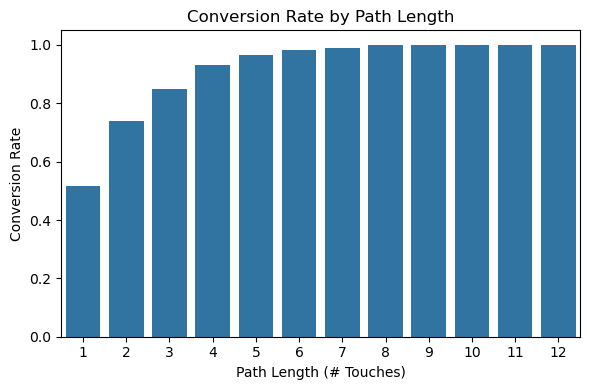

In [32]:
plt.figure(figsize=(6,4))
sns.barplot(data=pathlen_summary, x="n_touches", y="cvr")
plt.title("Conversion Rate by Path Length")
plt.xlabel("Path Length (# Touches)")
plt.ylabel("Conversion Rate")
plt.tight_layout()
plt.show()

In [33]:
daily = (
    df.set_index("Timestamp")
      .resample("D")
      .agg(events=("User ID","count"),
           conversions=("conversion_flag","sum"))
      .reset_index()
)
daily["cvr"] = daily["conversions"] / daily["events"]

print("Daily trends (head):")
print(daily.head())

Daily trends (head):
                  Timestamp  events  conversions       cvr
0 2025-02-10 00:00:00+00:00    4919         2446  0.497256
1 2025-02-11 00:00:00+00:00    5081         2498  0.491636


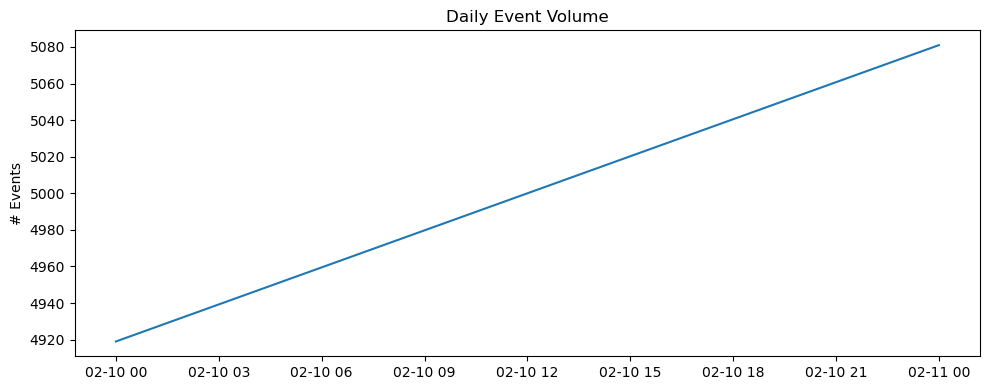

In [34]:
plt.figure(figsize=(10,4))
plt.plot(daily["Timestamp"], daily["events"])
plt.title("Daily Event Volume")
plt.ylabel("# Events")
plt.tight_layout()
plt.show()

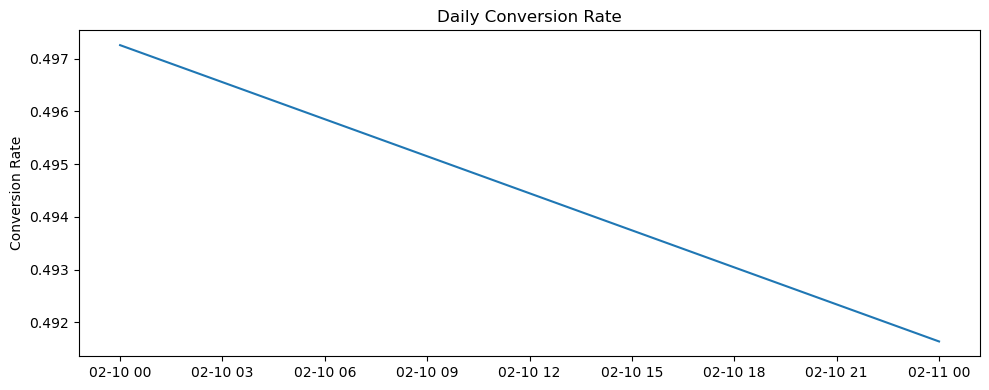

In [35]:
plt.figure(figsize=(10,4))
plt.plot(daily["Timestamp"], daily["cvr"])
plt.title("Daily Conversion Rate")
plt.ylabel("Conversion Rate")
plt.tight_layout()
plt.show()

In [36]:
weekly = (
    df.set_index("Timestamp")
      .resample("W")
      .agg(events=("User ID","count"),
           conversions=("conversion_flag","sum"))
      .reset_index()
)
weekly["cvr"] = weekly["conversions"] / weekly["events"]

print("\nWeekly trends (head):")
print(weekly.head())


Weekly trends (head):
                  Timestamp  events  conversions     cvr
0 2025-02-16 00:00:00+00:00   10000         4944  0.4944


In [38]:
top_channels = df["Channel"].value_counts().head(5).index.tolist()

daily_channels = (
    df[df["Channel"].isin(top_channels)]
      .set_index("Timestamp")
      .groupby("Channel")
      .resample("D")["User ID"].count()
      .rename("events")
      .reset_index()
)


/var/folders/2y/200s60hs0g5bg1dmy0zrklmr0000gn/T/ipykernel_53364/913138996.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby("Channel")


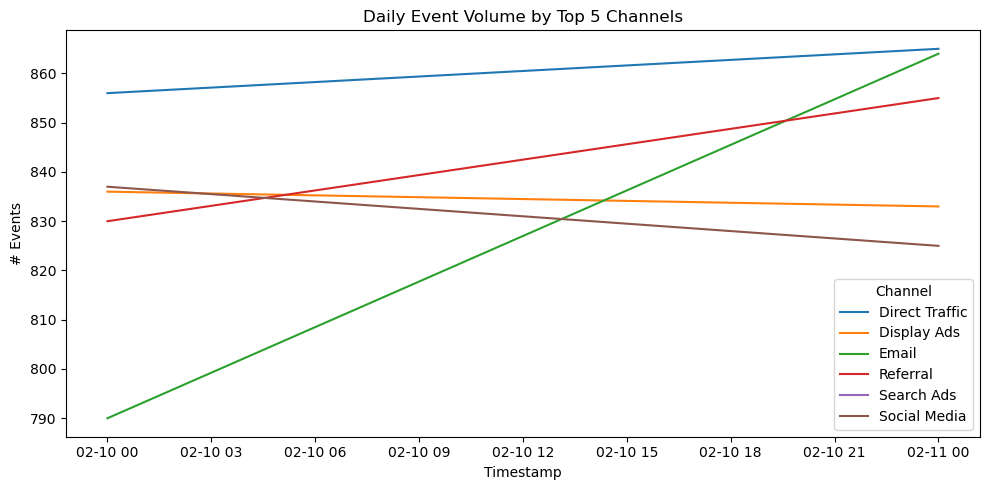

In [39]:
plt.figure(figsize=(10,5))
sns.lineplot(data=daily_channels, x="Timestamp", y="events", hue="Channel")
plt.title("Daily Event Volume by Top 5 Channels")
plt.ylabel("# Events")
plt.tight_layout()
plt.show()

In [40]:
df_sorted = df.sort_values(["User ID", "Timestamp"])

In [41]:
first_touch = df_sorted.groupby("User ID").head(1)
first_touch_summary = (
    first_touch.groupby("Channel")["conversion_flag"]
               .mean()
               .reset_index()
               .rename(columns={"conversion_flag": "first_touch_cvr"})
               .sort_values("first_touch_cvr", ascending=False)
)

print("First-touch conversion rates by channel:")
print(first_touch_summary)

First-touch conversion rates by channel:
          Channel  first_touch_cvr
1     Display Ads         0.516260
0  Direct Traffic         0.507157
5    Social Media         0.498934
2           Email         0.491111
3        Referral         0.483539
4      Search Ads         0.457701


/var/folders/2y/200s60hs0g5bg1dmy0zrklmr0000gn/T/ipykernel_53364/1985667399.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  first_touch.groupby("Channel")["conversion_flag"]


In [42]:
last_touch = df_sorted.groupby("User ID").tail(1)
last_touch_summary = (
    last_touch.groupby("Channel")["conversion_flag"]
              .mean()
              .reset_index()
              .rename(columns={"conversion_flag": "last_touch_cvr"})
              .sort_values("last_touch_cvr", ascending=False)
)

print("\nLast-touch conversion rates by channel:")
print(last_touch_summary)


Last-touch conversion rates by channel:
          Channel  last_touch_cvr
3        Referral        0.549451
1     Display Ads        0.508547
2           Email        0.494737
5    Social Media        0.482533
4      Search Ads        0.479167
0  Direct Traffic        0.461840


/var/folders/2y/200s60hs0g5bg1dmy0zrklmr0000gn/T/ipykernel_53364/1279595037.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  last_touch.groupby("Channel")["conversion_flag"]


In [43]:
from pathlib import Path

In [44]:
Path("data/processed").mkdir(parents=True, exist_ok=True)

# Choose only the clean fields we need downstream
clean_cols = ["User ID", "Timestamp", "Channel", "Campaign", "conversion_flag"]

df_clean = df[clean_cols].copy()
df_clean.to_parquet("data/processed/events_clean.parquet", index=False)